In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv("../Merging/Merged_Data.csv")
print(data.columns)
data.head(5)

Index(['period', 'plantCode', 'plantName', 'fuel2002', 'fuelTypeDescription',
       'state', 'stateDescription', 'primeMover', 'total-consumption',
       'total-consumption-units',
       ...
       'TEMPEXT_BASE40', 'TEMPEXT_BASE45', 'TEMPEXT_BASE50', 'OVER_60',
       'OVER_70', 'OVER_80', 'UNDER_40', 'UNDER_30', 'UNDER_20',
       'SUM_OVER_UNDER'],
      dtype='object', length=111)


,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,TEMPEXT_BASE40,TEMPEXT_BASE45,TEMPEXT_BASE50,OVER_60,OVER_70,OVER_80,UNDER_40,UNDER_30,UNDER_20,SUM_OVER_UNDER
0,2020-01-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,84432,MMBtu per Mcf,...,23.723333,18.723333,14.123333,0.600000,0.300000,0.0,0.0,0.0,0.0,0.900000
1,2020-12-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,11343,MMBtu per Mcf,...,17.293548,12.487097,8.706452,0.354839,0.032258,0.0,0.0,0.0,0.0,0.387097
2,2023-08-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,109965,MMBtu per Mcf,...,46.403226,41.403226,36.403226,1.000000,1.000000,1.0,0.0,0.0,0.0,3.000000
3,2023-04-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,12548,MMBtu per Mcf,...,32.903333,27.903333,22.903333,1.000000,0.833333,0.0,0.0,0.0,0.0,1.833333
4,2023-02-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,96587,MMBtu per Mcf,...,25.867857,20.867857,15.867857,0.785714,0.357143,0.0,0.0,0.0,0.0,1.142857


In [6]:
# Load cluster labels
with open('Norm_Plant_Clusters.p', 'rb') as f:
    cluster_labels = pickle.load(f)

print(cluster_labels)

{'N_KM2':      N_plantCode  N_KM2_0  N_KM2_1
0              9      0.0      1.0
1             99      0.0      1.0
2            136      1.0      0.0
3            298      1.0      0.0
4            550      0.0      1.0
..           ...      ...      ...
478        66596      1.0      0.0
479        66597      1.0      0.0
480        66612      1.0      0.0
481        66613      1.0      0.0
482        66614      1.0      0.0

[483 rows x 3 columns], 'N_H2':      N_plantCode  N_H2_0  N_H2_1
0              9     1.0     0.0
1             99     1.0     0.0
2            136     1.0     0.0
3            298     1.0     0.0
4            550     1.0     0.0
..           ...     ...     ...
478        66596     1.0     0.0
479        66597     1.0     0.0
480        66612     1.0     0.0
481        66613     1.0     0.0
482        66614     1.0     0.0

[483 rows x 3 columns], 'N_KM3':      N_plantCode  N_KM3_0  N_KM3_1  N_KM3_2
0              9      0.0      0.0      1.0
1             99   

In [27]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2019-01-01']

In [29]:
# Define the time periods and features for training and testing
start_train = '2019-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'
model_features = ['ELEVATION', 'TEMP',
       'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP','TEMPEXT_BASE40', 'TEMPEXT_BASE45', 'TEMPEXT_BASE50', 
       'OVER_60', 'OVER_70', 'OVER_80', 'UNDER_40', 'UNDER_30', 'UNDER_20',
       'SUM_OVER_UNDER', 'LATITUDE','LONGITUDE','Zip','plantCode']
# add feature for distance to weather station from power plant?

In [30]:
# How to do cross validation folds? Feature ablation
# For cross validation: could do (4 different folds, increasing data (year 1, year 1-2, year 1-3, year 1-4))

def train_test_and_plot(data, model, start_train, end_train, start_test, end_test, model_features):
    # Exclude negative consumption values
    data = data[data['total-consumption'] > 0]

    # Convert 'state' column to categorical type
    data['state'] = data['state'].astype('category')
    
    # Extract features and target variable
    X = data[model_features]
    y = data['total-consumption']

    # Filter the data for training and testing
    train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
    test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

    # Extract features and target variable for training
    X_train = train_data[model_features]
    y_train = train_data['total-consumption']

    # Extract features and target variable for testing
    X_test = test_data[model_features]
    y_test = test_data['total-consumption']

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Could use mean absolute error as an option (evaluating against the median instead of the average)
    # Reasonable baseline approach to use a combination of a squared error and R2 terms

    print('Model evaluation:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plotting the predicted vs. actual total consumption
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, c=test_data['state'].cat.codes, cmap='viridis', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plotting the diagonal line
    plt.title('Predicted vs. Actual Total Consumption')
    plt.xlabel('Actual Total Consumption')
    plt.ylabel('Predicted Total Consumption')
    plt.grid(True)

    plt.show()


    # Plotting predicted and actual values against timescale 'period'
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['period'], y_test, label='Actual', alpha=0.5)
    plt.scatter(test_data['period'], y_pred, label='Predicted', alpha=0.5)
    plt.title('Actual vs. Predicted Total Consumption Over Time')
    plt.xlabel('Period')
    plt.ylabel('Total Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


    # Perform PCA on the entire dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=20)  # Specify the number of components to retain
    pca.fit(X_scaled)

    # Visualize explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        top_features = np.array(model_features)[sorted_idx][-10:]  # Adjust the number of top features as needed
        pos = np.arange(top_features.shape[0]) + .5
        plt.figure(figsize=(10, 6))
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.show()

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_42848\276433868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 393750403909.0412
R-squared: 0.8614384125960608


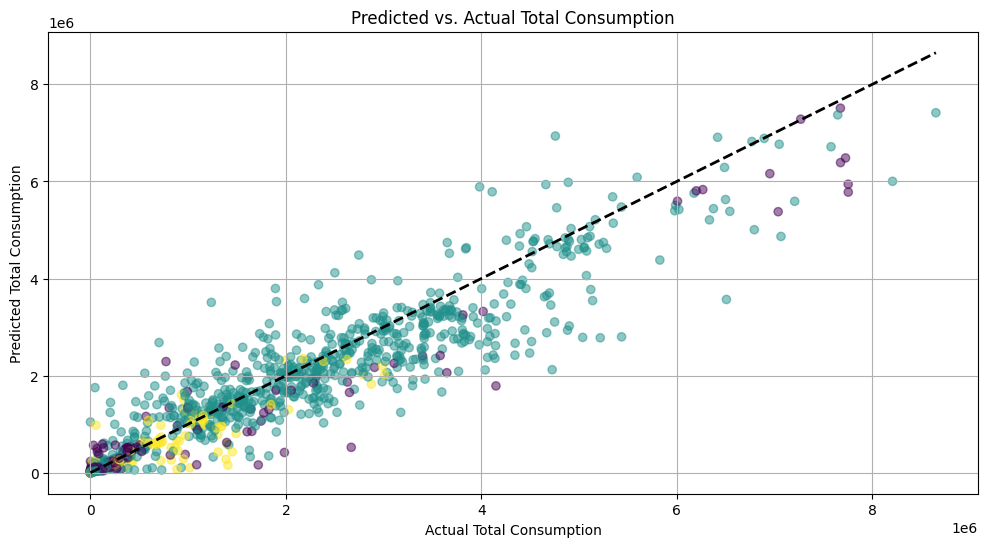

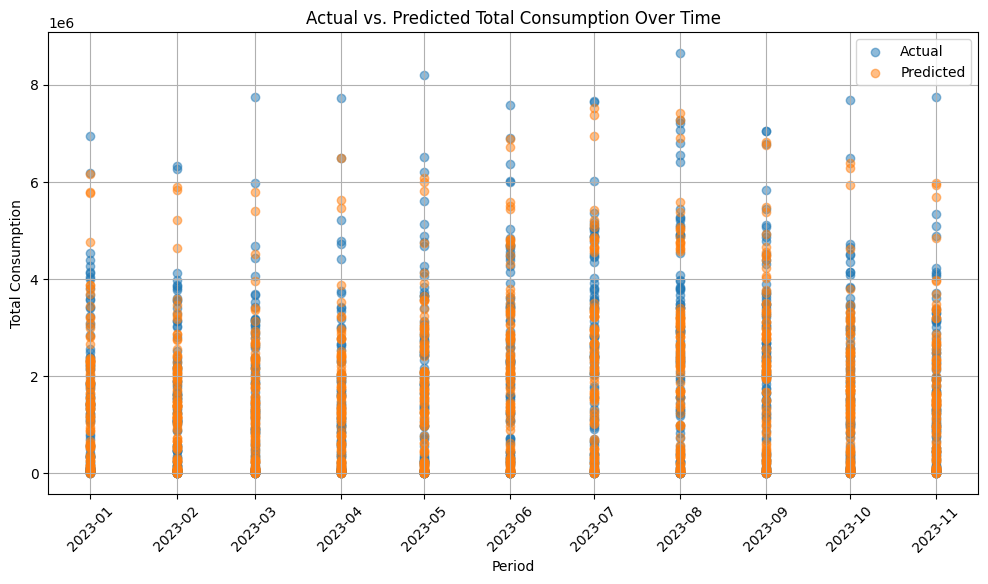

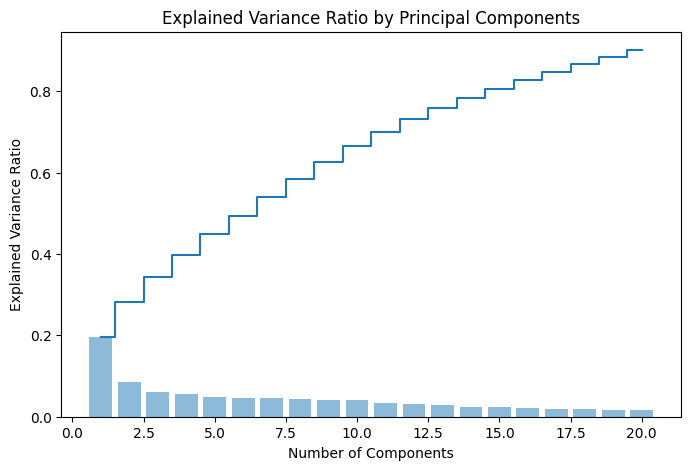

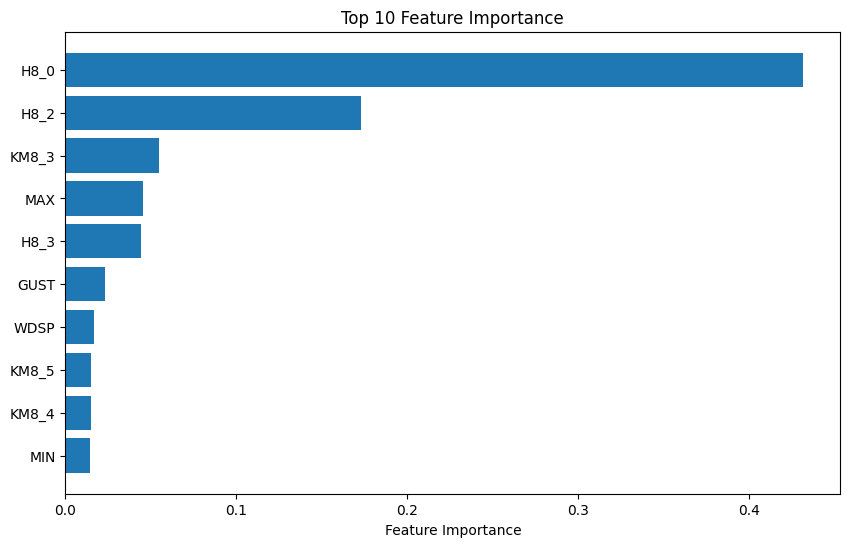

In [31]:
# Define the number of trees in the forest
n_estimators = 100  # Example number of trees, you can change it as needed

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=n_estimators)

# Call the function with the model and other parameters
train_test_and_plot(data, rf_model, start_train, end_train, start_test, end_test, model_features)

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_42848\276433868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 409557396996.85583
R-squared: 0.8558758987990294


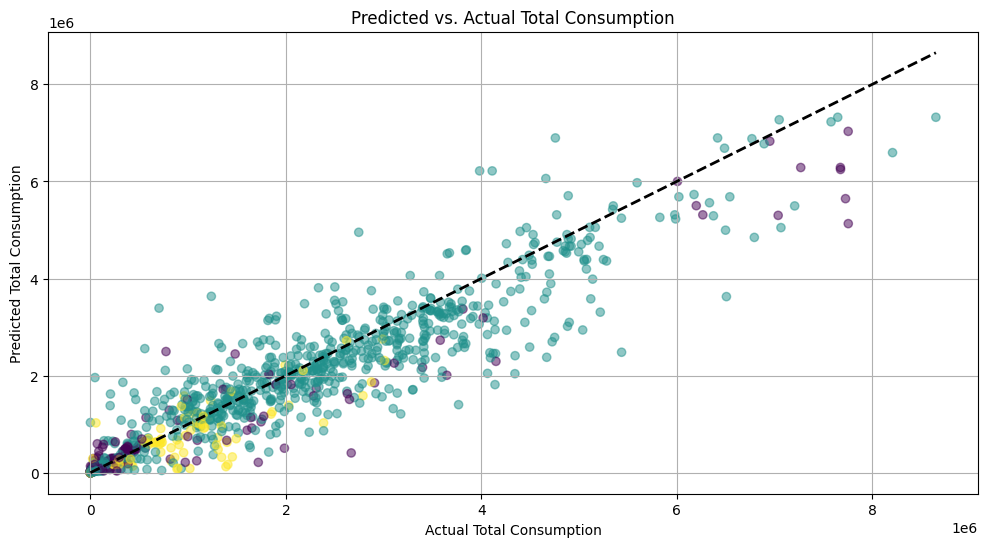

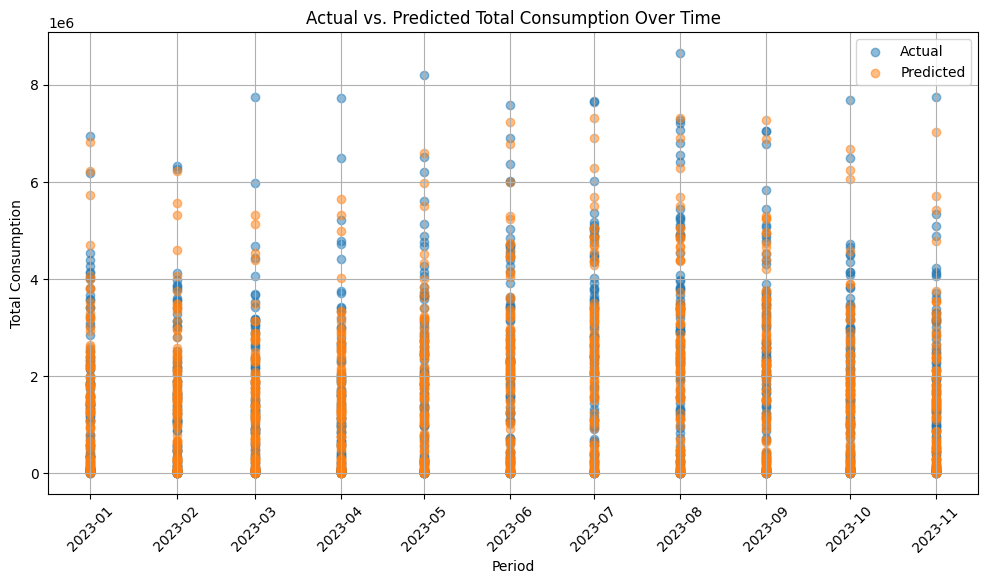

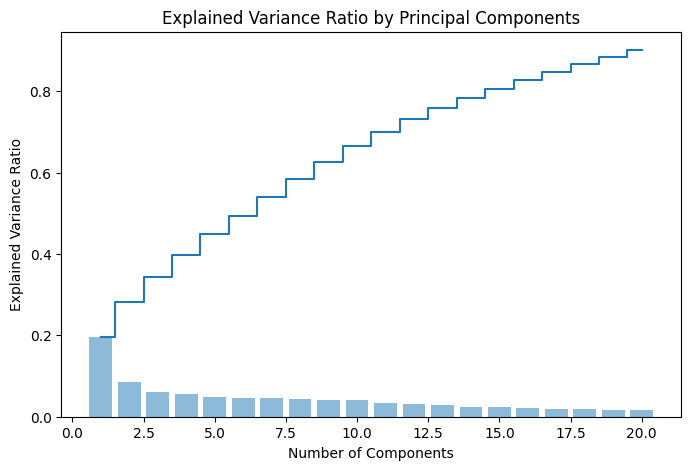

In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)

# Call the train_test_and_plot function
train_test_and_plot(data, knn_model, start_train, end_train, start_test, end_test, model_features)


C:\Users\nicoesse\AppData\Local\Temp\ipykernel_42848\276433868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 726560810293.8728
R-squared: 0.7443217372722554


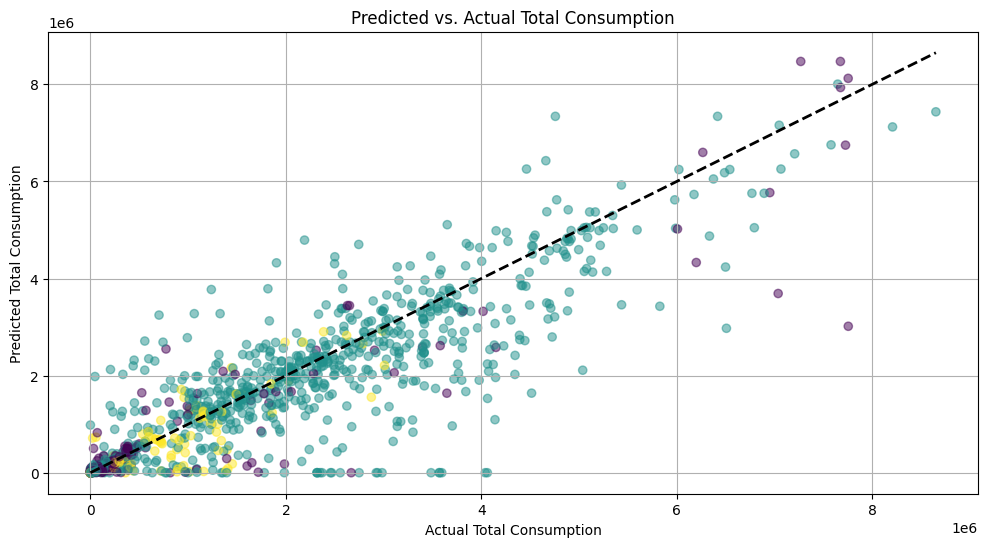

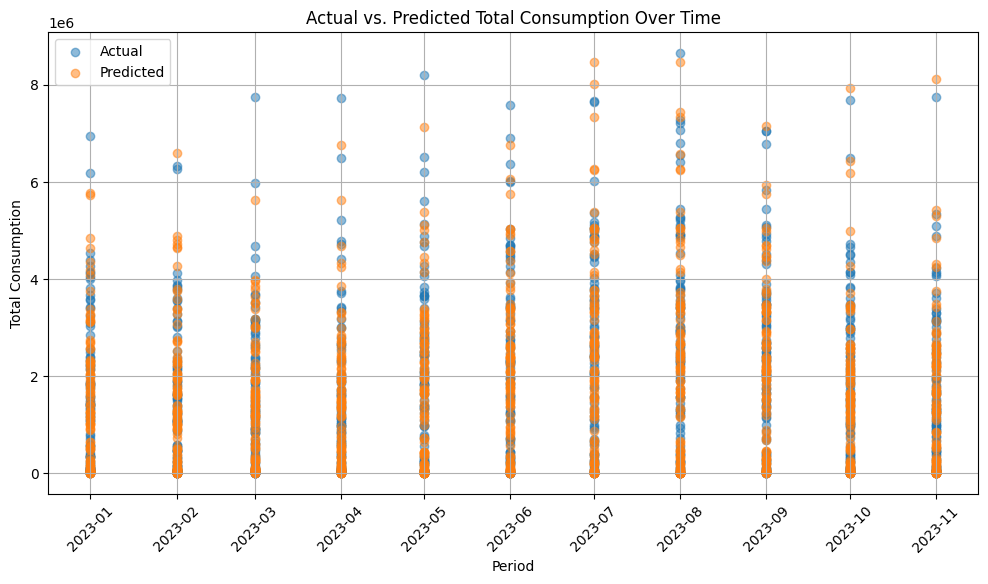

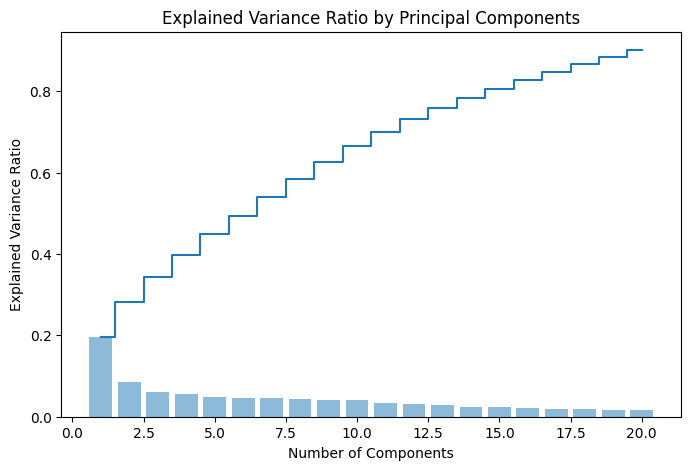

In [33]:
nb_model = GaussianNB()
train_test_and_plot(data, nb_model, start_train, end_train, start_test, end_test, model_features)
